In [1]:
import jax
import jax.numpy as jnp
import jax.random as jxr
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm

import sys
sys.path.append('../')
import utils
import inference
from models import wGPLDS, WeightSpaceGaussianProcess, ParamswGPLDS

import pandas as pd
import pynapple as nap
import requests, math, os
import tqdm
import sklearn
import seaborn as sns

/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data

path = "Mouse32-140822.nwb"
if path not in os.listdir("."):
    r = requests.get(f"https://osf.io/jb2gd/download", stream=True)
    block_size = 1024*1024
    with open(path, 'wb') as f:
        for data in tqdm.tqdm(r.iter_content(block_size), unit='MB', unit_scale=True,
            total=math.ceil(int(r.headers.get('content-length', 0))//block_size)):
            f.write(data)

data = nap.load_file("Mouse32-140822.nwb")

spikes = data["units"]  # Get spike timings
epochs = data["epochs"]  # Get the behavioural epochs (in this case, sleep and wakefulness)
angle = data["ry"]  # Get the tracked orientation of the animal

spikes_adn = spikes.getby_category("location")["adn"]  # Select only those units that are in ADn
adn_units = list(spikes_adn.keys())

/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


In [3]:
# Process data

# Constants
bin_size = 0.2 # 200ms bin size
step_size = 0.05
winsize = int(bin_size / step_size)  # Window size
trial_time_length = 10
n_trials = int((epochs['wake']['end'][0] - epochs['wake']['start'][0]) / trial_time_length)

bin_edges = jnp.arange(0, trial_time_length, step_size)

all_frs = []
all_conditions = []
for i in jnp.arange(1, n_trials + 1):
  trial_start = int(epochs['wake']['start'][0] + i * trial_time_length)
  if trial_start > epochs['wake']['end'][0]:
    break

  # Firing rates
  peth = nap.compute_perievent(
      data=spikes_adn.restrict(epochs['wake']), 
      tref=nap.Ts(trial_start), minmax=(0, trial_time_length), time_unit='s' 
  )

  frs = []
  for u in adn_units:
    counts = peth[u].count(step_size)

    counts = (
        counts.as_dataframe()
        .rolling(winsize, win_type="gaussian", min_periods=1, center=True)
        .mean(std=winsize) # take mean of window, with std passed to Gaussian window type
    )

    fr = counts * winsize
    frs.append(fr)

  frs = jnp.array(frs).squeeze().T # (n_bins, n_units)
  frs = jnp.sqrt(frs) # square root transform
  all_frs.append(frs)

  # Get the conditions for trial
  angle_Tsd = nap.compute_perievent(
    angle.restrict(epochs['wake']),
    tref=nap.Ts(trial_start), minmax=(0, trial_time_length), time_unit='s'
  )[0]

  _times = angle_Tsd.times()
  _angles = angle_Tsd.as_array()

  rounded_angles = jnp.array([_angles[jnp.abs(_times - b).argmin()] for b in bin_edges])

  conditions = jnp.stack([bin_edges, rounded_angles]).T
  all_conditions.append(conditions)

all_frs = jnp.array(all_frs)
all_conditions = jnp.array(all_conditions)
print(all_frs.shape, all_conditions.shape)

[xla_bridge.py][2024-11-11 16:47:15,042] INFO - Unable to initialize backend 'cuda': 
[xla_bridge.py][2024-11-11 16:47:15,042] INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[xla_bridge.py][2024-11-11 16:47:15,043] INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/pynapple/core/base_class.py:42: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/Users/victorgeadah_

(195, 200, 31) (195, 200, 2)


/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/pynapple/core/base_class.py:42: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/pynapple/core/base_class.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/pynapple/core/base_class.py:42: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/pynapple/core/base_class.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/pynapple/core/base_class.py:42: UserWarning: 

In [4]:
Y = all_frs
U = all_conditions
U = U[:, :, 1]  # Use only the angle

# Standardize

Y = (Y - Y.mean()) / Y.std()

# Randomly select trials for training and testing

B = Y.shape[0]
split = 0.8
partition = int(B * split)

key = jxr.PRNGKey(0)
indices = jxr.permutation(key, B)
train_indices = indices[:partition]
test_indices = indices[partition:]

Y_train, Y_test = Y[train_indices], Y[test_indices]
U_train, U_test = U[train_indices], U[test_indices]

In [5]:
num_theta_bins = 50

tuning_curves = nap.compute_1d_tuning_curves(
                    group=spikes_adn,
                    feature=angle,
                    nb_bins=num_theta_bins,
                    ep = epochs['wake'],
                    minmax=(0, 2 * jnp.pi)
                    )

tuning_curves = jnp.array([tuning_curves[u] for u in tuning_curves.keys()])
print(tuning_curves.shape)

(31, 50)


/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


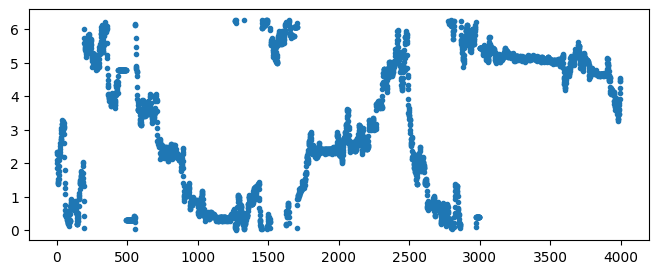

In [6]:
fig, ax = plt.subplots(figsize=[8,3])
ax.plot(U.flatten()[:4000], '.')

# Fit model

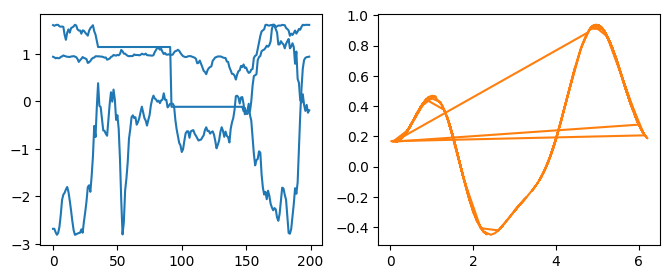

In [7]:
# Define model

latent_dim = 2
n_neurons = Y.shape[-1]

_sigma, _kappa, c_period = 1.0, 0.15, 2*jnp.pi
t_period = trial_time_length + 6 * _kappa
T2_basis_funcs = utils.T2_basis(5, _sigma, _kappa, t_period, c_period)
T1_basis_funcs = utils.T1_basis(5, _sigma, _kappa, c_period)

A_prior = WeightSpaceGaussianProcess(T1_basis_funcs, D1=latent_dim, D2=latent_dim)
b_prior = WeightSpaceGaussianProcess(T1_basis_funcs, D1=latent_dim, D2=1)
m0_prior = WeightSpaceGaussianProcess(T1_basis_funcs, D1=latent_dim, D2=1)
C_prior = WeightSpaceGaussianProcess(T1_basis_funcs, D1=n_neurons, D2=latent_dim)
model = wGPLDS(
    wgps={
        'A': A_prior, 
        'b': b_prior,
        'C': C_prior,
        'm0': m0_prior,
        }, 
    state_dim=latent_dim, 
    emission_dim=n_neurons,
    )

# conditions = jnp.vstack([t_range, coherencies[7] * jnp.ones_like(t_range)])

fig, axs = plt.subplots(figsize=[8,3], ncols=2)
for i in range(3):
    axs[0].plot(A_prior.sample(jxr.PRNGKey(3), U[i])[:,0,0], c='tab:blue');
    axs[1].plot(U[i], A_prior.sample(jxr.PRNGKey(3), U[i])[:,0,1], c='tab:orange')
    # axs[1].plot(U[i][:,1], A_prior.sample(jxr.PRNGKey(3), U[i])[:,0,1], '.', c='tab:orange')

In [8]:
# Initialize A and b weights as ring attractor

def ring_weights(kappa, sigma):
    def weight_space_coefficients(m):
        return jnp.sqrt(utils.squared_exponential_spectral_measure(m, sigma, kappa))

    # A weights

    ring_wA_weights = jnp.zeros((len(A_prior.basis_funcs), 2, 2))
    # A[0,0] = 1/2 - cos(2 t)/2
    ring_wA_weights = ring_wA_weights.at[11,0,0].set(1/weight_space_coefficients(0) * 1/2)
    ring_wA_weights = ring_wA_weights.at[15,0,0].set(-1/weight_space_coefficients(2) * 1/2)

    # A[1,1] = 1/2 + cos(2 t)/2
    ring_wA_weights = ring_wA_weights.at[11,1,1].set(1/weight_space_coefficients(0) * 1/2)
    ring_wA_weights = ring_wA_weights.at[15,1,1].set(1/weight_space_coefficients(2) * 1/2)

    # A[0,1] = -sin(2 t)/2
    ring_wA_weights = ring_wA_weights.at[14,1,0].set(-1/weight_space_coefficients(2) * 1/2)
    ring_wA_weights = ring_wA_weights.at[14,0,1].set(-1/weight_space_coefficients(2) * 1/2)

    # b weights

    ring_wb_weights = jnp.zeros((len(b_prior.basis_funcs), 2, 1))

    ring_wb_weights = jnp.zeros((len(b_prior.basis_funcs), b_prior.D1, b_prior.D2)) # len_basis D1 D2
    ring_wb_weights = ring_wb_weights.at[12,0,0].set(1/weight_space_coefficients(1))
    ring_wb_weights = ring_wb_weights.at[13,1,0].set(1/weight_space_coefficients(1))

    return ring_wA_weights, ring_wb_weights

Iter 200/200, log-prob = -737597.50, marginal log-lik = -540924.06: 100%|██████████| 200/200 [02:14<00:00,  1.49it/s]


Test log likelihood: -133800.5


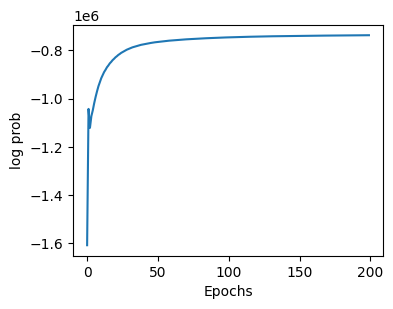

In [9]:
num_timesteps = Y.shape[1]

ring_wA_weights, ring_wb_weights = ring_weights(_kappa, _sigma)

# Initialize
seed = 2 # use 0 for plotting
A_key, b_key, C_key, m0_key = jxr.split(jxr.PRNGKey(seed), 4)
initial_params = ParamswGPLDS(
    dynamics_gp_weights =  A_prior.sample_weights(A_key),# ring_wA_weights, 
    Q = jnp.eye(latent_dim),
    R = jnp.eye(n_neurons),
    m0 = jnp.zeros(latent_dim),
    m0_gp_weights = m0_prior.sample_weights(m0_key),
    S0 = jnp.eye(latent_dim),
    emissions_gp_weights = C_prior.sample_weights(C_key),
    bias_gp_weights = b_prior.sample_weights(b_key),
    Cs = jnp.tile(jxr.normal(C_key, (n_neurons, latent_dim)), (num_timesteps, 1, 1)), #C_prior.sample(C_key, U[0]), #jnp.tile(jxr.normal(C_key, (n_neurons, latent_dim)), (num_timesteps, 1, 1)), #C_prior.sample(C_key, U[0]),
    bs = None, #jnp.zeros((num_timesteps-1, latent_dim)),# None, #b_prior.sample(b_key, U[0]).squeeze(), #jnp.zeros((num_timesteps-1, latent_dim)), #b_prior.sample(b_key, conditions).squeeze(),
)

# Fit model
params, log_probs = inference.fit_em(model, initial_params, emissions=Y_train, conditions=U_train, num_iters=200)
test_ll = model.marginal_log_lik(params, emissions=Y_test, conditions=U_test)
print(f"Test log likelihood: {test_ll}")

# Show results
fig, ax = plt.subplots(figsize=[4,3])
ax.plot(log_probs)
ax.set_ylabel('log prob')
ax.set_xlabel('Epochs');

In [10]:
# _, num_timesteps, n_neurons = Y_train.shape
# latent_dim = 2
# _sigma, _kappa, c_period = 1.0, 0.2, 2*jnp.pi
# t_period = trial_time_length + 6 * _kappa

# # # Priors and model 
# # A_prior = WeightSpaceGaussianProcess(T1_basis_funcs, D1=latent_dim, D2=latent_dim)
# # b_prior = WeightSpaceGaussianProcess(T1_basis_funcs, D1=latent_dim, D2=1)
# # m0_prior = WeightSpaceGaussianProcess(T1_basis_funcs, D1=latent_dim, D2=1)
# # C_prior = WeightSpaceGaussianProcess(T1_basis_funcs, D1=n_neurons, D2=latent_dim)

# # model = wGPLDS(
# #     wgps={'A': A_prior, 'b': b_prior, 'C': C_prior, 'm0': m0_prior,}, 
# #     state_dim=latent_dim, emission_dim=n_neurons,
# #     )

# # Search
# for seed in [2]:
#     A_key, b_key, C_key, m0_key = jxr.split(jxr.PRNGKey(seed), 4)
#     for _kappa in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4]:
#     # for a in jnp.linspace(0.1, 5.0, 10):
#     #     print(f"a: {a}, seed: {seed}")

#         # _weights_sincos = jnp.zeros((len(b_prior.basis_funcs), b_prior.D1, b_prior.D2)) # len_basis D1 D2
#         # _weights_sincos = _weights_sincos.at[12,0,0].set(a)
#         # _weights_sincos = _weights_sincos.at[13,1,0].set(a)

#         # T2_basis_funcs = utils.T2_basis(5, _sigma, _kappa, t_period, c_period)
#         T1_basis_funcs = utils.T1_basis(5, _sigma, _kappa, c_period)

#         # Priors and model 
#         A_prior = WeightSpaceGaussianProcess(T1_basis_funcs, D1=latent_dim, D2=latent_dim)
#         b_prior = WeightSpaceGaussianProcess(T1_basis_funcs, D1=latent_dim, D2=1)
#         m0_prior = WeightSpaceGaussianProcess(T1_basis_funcs, D1=latent_dim, D2=1)
#         C_prior = WeightSpaceGaussianProcess(T1_basis_funcs, D1=n_neurons, D2=latent_dim)
        
#         model = wGPLDS(
#             wgps={'A': A_prior, 'b': b_prior, 'C': C_prior, 'm0': m0_prior,}, 
#             state_dim=latent_dim, emission_dim=n_neurons,
#             )

#         # Initialize
#         A_key, b_key, C_key, m0_key = jxr.split(jxr.PRNGKey(seed), 4)
#         initial_params = ParamswGPLDS(
#             dynamics_gp_weights =  A_prior.sample_weights(A_key),
#             Q = jnp.eye(latent_dim),
#             R = jnp.eye(n_neurons),
#             m0 = jnp.zeros(latent_dim),
#             m0_gp_weights = m0_prior.sample_weights(m0_key),
#             S0 = jnp.eye(latent_dim),
#             emissions_gp_weights = C_prior.sample_weights(C_key),
#             bias_gp_weights = b_prior.sample_weights(b_key),
#             Cs = None,
#             bs = None,
#         )

#         # Fit model
#         params, log_probs = model.fit_em(initial_params, emissions=Y_train, conditions=U_train, num_iters=200, verbose=False)

#         train_ll = model.marginal_log_lik(params, emissions=Y_train, conditions=U_train)
#         test_ll = model.marginal_log_lik(params, emissions=Y_test, conditions=U_test)

#         print(f"'seed': {seed}, 'kappa': {_kappa}, 'test_ll': {test_ll:.2f}, 'train_ll': {train_ll:.2f}, 'log_prob': {log_probs[-1]:.2f}")
#         print("=" * 50)

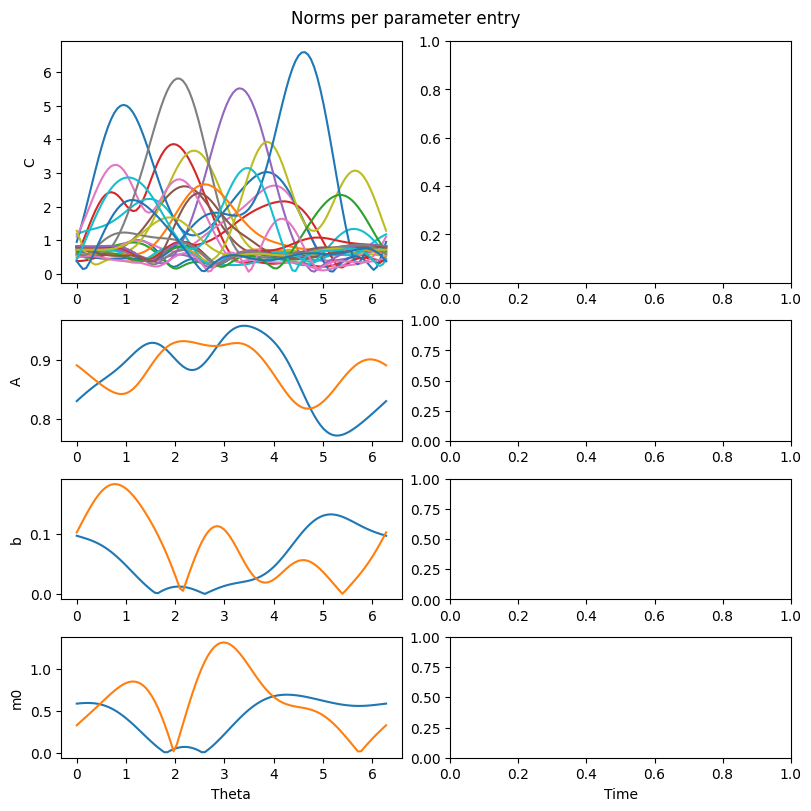

In [11]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=[8,8], height_ratios=[2,1,1,1], constrained_layout=True)

thetas = jnp.linspace(0, 2*jnp.pi, 100)
_theta_conditions = jnp.stack([jnp.ones_like(thetas), thetas]).T
_t_conditions = jnp.stack([bin_edges, jnp.ones(len(bin_edges))]).T

for i, (label, prior, weights) in enumerate(zip(
        ['C', 'A', 'b', 'm0'],
        [C_prior, A_prior, b_prior, m0_prior], 
        [params.emissions_gp_weights, params.dynamics_gp_weights, params.bias_gp_weights, params.m0_gp_weights]
        )):
    params_theta = prior(weights, thetas)
    # params_t = prior(weights, _t_conditions)

    axs[i, 0].plot(thetas, jnp.linalg.norm(params_theta, axis=-1))
    # axs[i, 1].plot(bin_edges, jnp.linalg.norm(params_t, axis=-1))
    axs[i, 0].set_ylabel(label)

axs[-1, 0].set_xlabel('Theta')
axs[-1, 1].set_xlabel('Time')

# axs[0].plot(thetas, jnp.linalg.norm(Cs_theta, axis=-1));
# axs[1].plot(bin_edges, jnp.linalg.norm(Cs_t, axis=-1));
fig.suptitle('Norms per parameter entry')
plt.show()

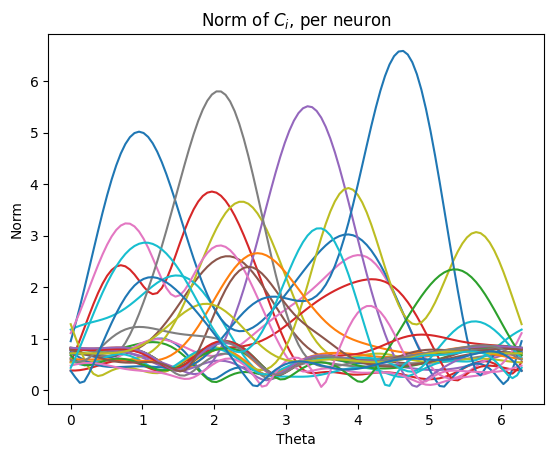

In [12]:
thetas = jnp.linspace(0, 2*jnp.pi, 100)
Cs_theta = C_prior(params.emissions_gp_weights, thetas)
# bs_t = b_prior(params.bias_gp_weights, _t_conditions)

fig, ax = plt.subplots()
ax.plot(thetas, jnp.linalg.norm(Cs_theta, axis=-1))
ax.set_xlabel('Theta')
ax.set_ylabel('Norm')
ax.set_title('Norm of $C_{i}$, per neuron')
# plt.savefig('figures/HD_C_norm_theta.png', dpi=300)
plt.show()

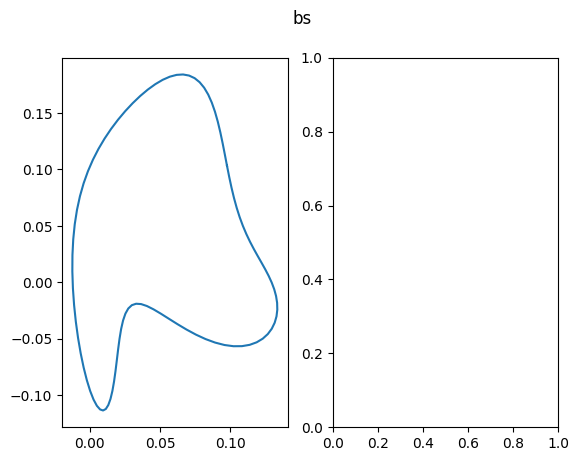

In [13]:
thetas = jnp.linspace(0, 2*jnp.pi, 100)
_theta_conditions = jnp.stack([3*jnp.ones_like(thetas), thetas]).T
# _t_conditions = jnp.stack([bin_edges, jnp.ones(len(bin_edges))]).T
bs_theta = b_prior(params.bias_gp_weights, thetas)
# bs_t = b_prior(params.bias_gp_weights, _t_conditions)

fig, axs = plt.subplots(ncols=2)
axs[0].plot(*bs_theta.squeeze().T);
# axs[1].plot(bin_edges, bs_t.squeeze());
fig.suptitle('bs')
plt.show()

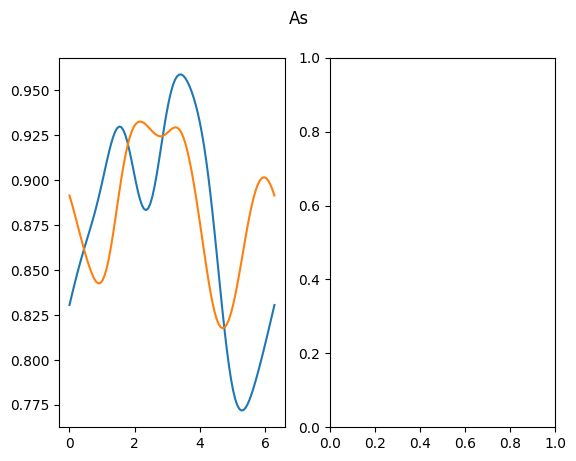

In [14]:
thetas = jnp.linspace(0, 2*jnp.pi, 100)
# _theta_conditions = jnp.stack([3*jnp.ones_like(thetas), thetas]).T
# _t_conditions = jnp.stack([bin_edges, jnp.ones(len(bin_edges))]).T
As_theta = A_prior(params.dynamics_gp_weights, thetas)
# As_t = A_prior(params.dynamics_gp_weights, _t_conditions)

fig, axs = plt.subplots(ncols=2)
axs[0].plot(thetas, jnp.linalg.norm(As_theta, axis=-1));
# axs[1].plot(bin_edges, jnp.linalg.norm(As_t, axis=-1));
fig.suptitle('As')
plt.show()

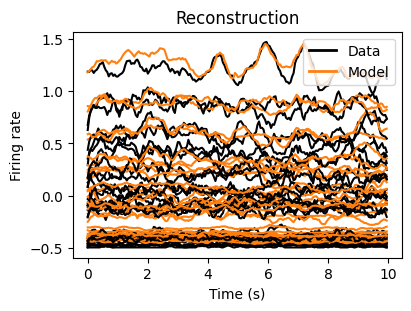

In [15]:
def reconstruct_y(b):
    _, (filtered_means, _), (smoothed_means, smoothed_covs, _) = model.smoother(params, Y[b], U[b])
    Cs = C_prior(params.emissions_gp_weights, U[b])
    _reconstructed_ys = jnp.einsum('tnl,tl->tn', Cs, smoothed_means)
    return _reconstructed_ys

reconstructed_ys = jax.vmap(reconstruct_y)(jnp.arange(len(Y)))
fig, ax = plt.subplots(figsize=[4,3], constrained_layout=True);
for i in range(n_neurons):
    ax.plot(bin_edges, Y.mean(0)[:,i], c='k', alpha=1.0)
    ax.plot(bin_edges, reconstructed_ys.mean(0)[:,i], c='tab:orange', alpha=1.0)
    # ax.fill_between(
    #     bin_edges,
    #     reconstructed_ys.mean(0)[:,i] - reconstructed_ys.std(0)[:,i], 
    #     reconstructed_ys.mean(0)[:,i] + reconstructed_ys.std(0)[:,i], 
    #     color='tab:orange', alpha=0.3)

# ax.plot(Y.mean(0).mean(1), c='k', label='Data')
# ax.plot(reconstructed_ys.mean(0).mean(1), c='tab:orange', label='Model')

ax.set_ylabel('Firing rate')
ax.set_title('Reconstruction')

lines = [plt.Line2D([0], [0], color='k', lw=2), plt.Line2D([0], [0], color='tab:orange', lw=2)]
ax.legend(lines, ['Data', 'Model'])
ax.set_xlabel('Time (s)');
# plt.savefig(f'figures/headdirection_reconstruction.eps', format='eps')

In [16]:
all_smoothed_means = jax.vmap(lambda b: model.smoother(params, Y[b], U[b])[2][0])(jnp.arange(len(Y)))
all_smoothed_means.shape

(195, 200, 2)

Text(0, 0.5, 'Mean x')

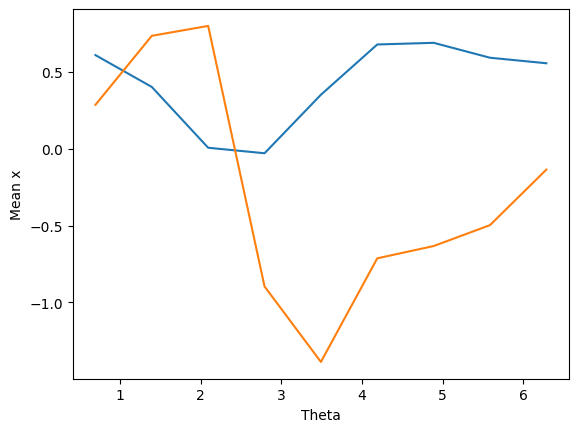

In [17]:
all_smoothed_means = jax.vmap(lambda b: model.smoother(params, Y[b], U[b])[2][0])(jnp.arange(len(Y)))
theta_range = jnp.linspace(0, 2*jnp.pi, 10)

# Bin U into the theta_range bins
U_digit = jnp.digitize(U, theta_range)

# Print mean x per bin
mean_x_per_bin = jnp.array([all_smoothed_means[U_digit == i].mean(0) for i in range(0, len(theta_range))])

plt.plot(theta_range, mean_x_per_bin)
plt.xlabel('Theta')
plt.ylabel('Mean x')

(50, 2)


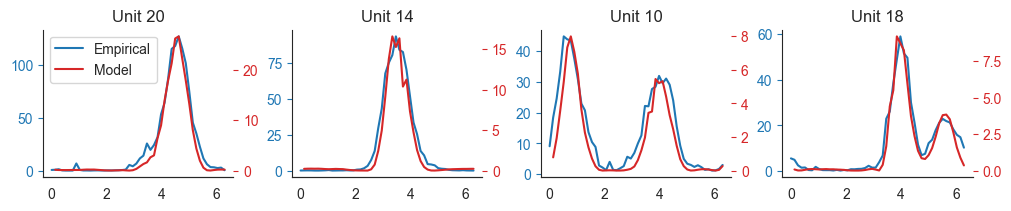

In [18]:
sns.set_style('white')

num_theta_bins = 50

thetas = jnp.linspace(0, 2*jnp.pi, num_theta_bins)

# E[x | theta]

all_smoothed_means = jax.vmap(lambda b: model.smoother(params, Y[b], U[b])[2][0])(jnp.arange(len(Y)))
U_digit = jnp.digitize(U, thetas)
mean_x_per_bin = jnp.array([all_smoothed_means[U_digit == i].mean(0) for i in range(0, len(thetas))])
print(mean_x_per_bin.shape)

# Tuning curves
tuning_curves = nap.compute_1d_tuning_curves(
                    group=spikes_adn,
                    feature=angle,
                    nb_bins=num_theta_bins,
                    ep = epochs['wake'],
                    minmax=(0, 2 * jnp.pi)
                    )

tuning_curves = jnp.array([tuning_curves[u] for u in tuning_curves.keys()])
tuning_norm_sorted = jnp.argsort(jnp.linalg.norm(tuning_curves, axis=-1))[::-1]

reds = plt.get_cmap('Reds')

_U, _S, _ = jnp.linalg.svd(params.Q)
H = jnp.linalg.pinv(jnp.diag(jnp.sqrt(_S))) @ _U.T

Cs = C_prior(params.emissions_gp_weights, thetas)

Cx = jnp.einsum('bni,bi->bn', Cs, mean_x_per_bin)

fig, axs = plt.subplots(figsize=[10,2], ncols=4, constrained_layout=True)
axs = axs.flatten()

for i, j in enumerate(tuning_norm_sorted[:len(axs)]):
    axs[i].plot(thetas, tuning_curves[j], c='tab:blue', label='Empirical');
    axs[i].tick_params(axis='y', colors='tab:blue')
    ax2 = axs[i].twinx()
    sns.despine(fig, ax2, left=True, top=True, right=True)

    # for t in [1]:
        # _conditions = jnp.stack([t*jnp.ones_like(thetas), thetas]).T
    # Cs = jnp.einsum('tij,jn->tin', Cs, H)

    # C_norm_sorted = jnp.argsort(jnp.linalg.norm(jnp.linalg.norm(Cs, axis=-1), axis=0))[::-1]
    
    # ax2.plot(thetas, jnp.square(jnp.linalg.norm(Cs, axis=-1))[:,j], c='tab:red', zorder=-1, label=r'$||C(\theta)_n||$'); # c=reds(t/len(bin_edges[::20])),
    ax2.plot(thetas, jnp.square(Cx[:,j]), c='tab:red', label='Model')
    # Color ax
    # ax2.spines['left'].set_color('tab:blue')
    ax2.tick_params(axis='y', colors='tab:red')
    axs[i].set_title(f'Unit {j}')

# Add legend
lines = [axs[0].lines[0], ax2.lines[0]]
labels = [l.get_label() for l in lines]
axs[0].legend(lines, labels)

for ax in axs:
    sns.despine(ax=ax)

# fig.suptitle(r'Empirical tuning curves v.s. emission tuning for top 4 units')

# for ax in axs:
#     sns.despine(ax=ax, trim=True, offset=5)

# axs[1].set_title(r'Norm of $C(\theta)$, per neuron')
# axs[0].set_title('True tuning curves')
# axs[1].set_xlabel(r'$\theta$')
# axs[0].legend()
# plt.savefig('figures/HD_tuning_curves.eps', format='eps')

Text(0.5, 1.0, 'Smoothed latent states')

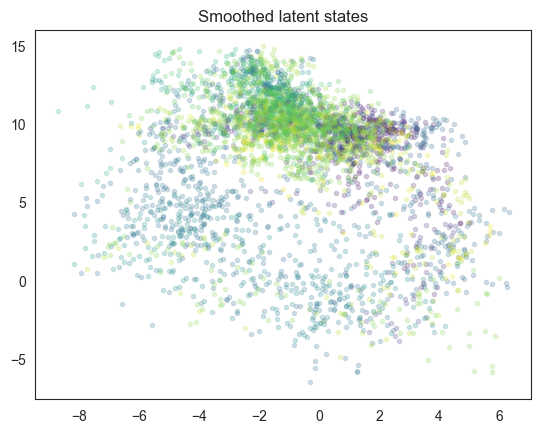

In [19]:
# smoothed_means = jax.vmap(lambda b: model.smoother(params, Y[b], U[b])[2][0])(jnp.arange(len(Y)))
# plt.plot(*smoothed_means.mean(0).T);

# eigvals, eigvecs = jnp.linalg.eig(A_prior(params.dynamics_gp_weights, U[1]).mean(0))

_U, _S, _ = jnp.linalg.svd(params.Q)
H = jnp.linalg.pinv(jnp.diag(jnp.sqrt(_S))) @ _U.T

def angle_to_color(theta):
    norm_theta = theta / (2 * jnp.pi)  # Normalize theta to [0, 1]
    return plt.cm.viridis(norm_theta)

for b in range(len(Y))[:20]:
    x_hat = model.smoother(params, Y[b], U[b])[2][0]
    x_hat = jnp.einsum('ij,tj->ti', H, x_hat)
    plt.plot(*x_hat.T, '.', alpha=0.2, color=angle_to_color(U[b][0]))
plt.title('Smoothed latent states')
    # plt.plot(U[b][:,1], x_hat[:,0], '.', alpha=0.3)

# # Plot eigenvectors
# plt.arrow(0, 0, eigvecs[0,0].real, eigvecs[0,1].real, color='r', head_width=0.1)
# plt.arrow(0, 0, eigvecs[1,0].real, eigvecs[1,1].real, color='r', head_width=0.1)

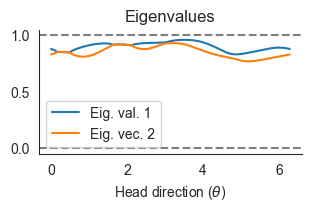

In [20]:
# plt.plot(A_prior(params.dynamics_gp_weights, U[1])[:,0]);
# plt.plot(A_prior(params.dynamics_gp_weights, U[1])[:,1]);
sns.set_style('white')
thetas = jnp.linspace(0, 2*jnp.pi, 200)
bs_theta = b_prior(params.bias_gp_weights, thetas).squeeze()
As_theta = A_prior(params.dynamics_gp_weights, thetas)

def get_angles(vs, correction=0):
    angles = jnp.arctan2(vs[:,1], vs[:,0]) + correction
    return jnp.where(angles < 0, angles + 2*jnp.pi, angles)

# Rotate first

_U, _S, _ = jnp.linalg.svd(params.Q)
H = jnp.linalg.pinv(jnp.diag(jnp.sqrt(_S))) @ _U.T
Hinv = _U @ jnp.diag(jnp.sqrt(_S))

bs_theta_rot = jnp.einsum('ij,tj->ti', H, bs_theta)
As_theta_rot = jnp.einsum('ij,tjk,kl->til', H, As_theta, Hinv)

# Plot 
eigvals, eigvecs = jnp.linalg.eig(As_theta_rot)

top_eigenval = jnp.where(eigvals.real[:,0] > eigvals.real[:,1], eigvals.real[:,0], eigvals.real[:,1])
bottom_eigenval = jnp.where(eigvals.real[:,0] < eigvals.real[:,1], eigvals.real[:,0], eigvals.real[:,1])

# Calculate angle of vector
angles_1 = get_angles(eigvecs[:,:,0].real)
angles_2 = get_angles(eigvecs[:,:,1].real)

top_eigvec_angles = jnp.where(top_eigenval == eigvals.real[:,0], angles_1, angles_2)
bottom_eigvec_angles = jnp.where(bottom_eigenval == eigvals.real[:,0], angles_1, angles_2) 

# angles_1 = jnp.where(angles_1 < 0, angles_1 + 2*jnp.pi, angles_1)
# angles_2 = jnp.where(angles_2 < 0, angles_2 + 2*jnp.pi, angles_2)

fig, ax = plt.subplots(figsize=[3,2], constrained_layout=True)
ax.plot(thetas, top_eigenval, label='Eig. val. 1')
ax.plot(thetas, bottom_eigenval, label='Eig. vec. 2')
ax.axhline(1,  c='tab:grey', ls='--', zorder=-1)
ax.axhline(0, c='tab:grey', ls='--', zorder=-1)
ax.legend()
ax.set_title('Eigenvalues')

# shift = 0.6

# axs[1].plot(thetas, (top_eigvec_angles + shift )  % jnp.pi, '.', c='tab:blue')
# # axs[1].plot(thetas, top_eigvec_angles % jnp.pi, '.', c='tab:blue')
# # axs[1].plot(thetas, angles_1+jnp.pi, '.', c='tab:blue')
# axs[1].plot(thetas, (bottom_eigvec_angles + shift) % jnp.pi, '.', c='tab:orange')
# # axs[1].plot(thetas, angles_2+jnp.pi, '.', c='tab:orange')
# axs[1].set_title('Eigenvector angles')
# axs[1].set_ylabel('absolute Angle (rad)')
# # db_theta = jnp.diff(bs_theta.squeeze(), axis=0)/(thetas[1] - thetas[0])
# # db_theta_angles = jnp.arctan2(db_theta[:,1], db_theta[:,0])
# # db_theta_angles = jnp.where(db_theta_angles < 0, db_theta_angles + 2*jnp.pi, db_theta_angles)
# # axs[2].plot(db_theta_angles, '.')
# b_theta_angles = get_angles(bs_theta_rot)
# b_theta_angles = jnp.where(b_theta_angles < 0, b_theta_angles + 2*jnp.pi, b_theta_angles) # Correct for negative angles

# axs[1].plot(thetas, (b_theta_angles + shift) % jnp.pi, '.', c='k', label='Angle of bias')
# axs[1].legend()

# for ax in axs:
ax.set_xlabel(r'Head direction ($\theta$)')
sns.despine(ax=ax)

# plt.savefig('figures/HD_eigvals_angles.eps')

/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:3042: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:3043: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  stop = asarray(stop, dtype=computation_dtype)
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-pack

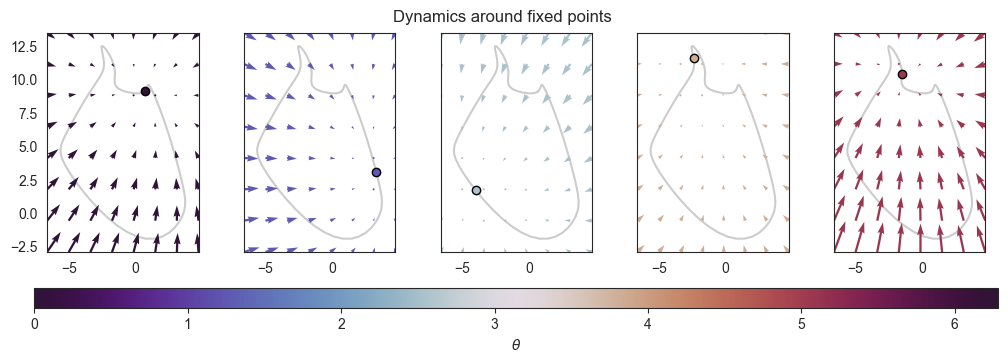

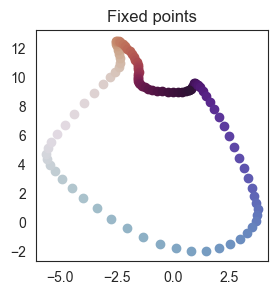

In [21]:
cmap = plt.cm.twilight_shifted
# Fixed points 

thetas = jnp.linspace(0, 2*jnp.pi, 100)
colors = cmap(thetas/(2*jnp.pi))
As_theta = A_prior(params.dynamics_gp_weights, thetas)
bs_theta = b_prior(params.bias_gp_weights, thetas).squeeze()

# Rotate

_U, _S, _ = jnp.linalg.svd(params.Q)
H = jnp.linalg.pinv(jnp.diag(jnp.sqrt(_S))) @ _U.T
Hinv = _U @ jnp.diag(jnp.sqrt(_S))

bs_theta_rot = jnp.einsum('ij,tj->ti', H, bs_theta)
As_theta_rot = jnp.einsum('ij,tjk,kl->til', H, As_theta, Hinv)


fixed_points = jax.vmap(lambda t: jax.scipy.linalg.solve(jnp.eye(latent_dim) - As_theta_rot[t], bs_theta_rot[t]))(jnp.arange(len(thetas)))


# for i, fp in enumerate(fixed_points):
#     ax.scatter(*fp, color=colors[i])

pad = 1.0
x_lims = (jnp.amin(fixed_points[:,0])-pad, jnp.amax(fixed_points[:,0])+pad)
y_lims = (jnp.amin(fixed_points[:,1])-pad, jnp.amax(fixed_points[:,1])+pad)

def plot_vector_field(A, ax, center=jnp.zeros((2,)), color='k'):
    x = jnp.linspace(*x_lims, 8)
    y = jnp.linspace(*y_lims, 8)
    X, Y = jnp.meshgrid(x, y)
    U = A[0, 0] * (X - center[0]) + A[0, 1] * (Y - center[1])
    V = A[1, 0] * (X - center[0]) + A[1, 1] * (Y - center[1])

    # Thicken the arrows
    ax.quiver(X, Y, U, V, units='width', scale=15, width=0.015, color=color)

sns.set_style('white')
fig = plt.figure(figsize=[10,3.5], constrained_layout=True)

# Make a 5 x 2 gridspec, and make the second row one long ax
ncols = 5
gs = fig.add_gridspec(1, ncols, wspace=0.1)
axs = [fig.add_subplot(gs[0, i]) for i in range(ncols)]
# ax1 = fig.add_subplot(gs[1, :])

indices = jnp.linspace(0, len(fixed_points), len(axs), endpoint=False, dtype=int)
for i, ax in zip(indices, axs):
    ax.scatter(*fixed_points[i], color=colors[i], edgecolors='k')
    ax.plot(*fixed_points.T, c='k', alpha=0.2, zorder=-1)
    plot_vector_field(As_theta_rot[i] - jnp.eye(2), ax=ax, center=fixed_points[i], color=colors[i])

for ax in axs:
    if ax is not axs[0]:
        ax.set_yticklabels([])
    ax.set_xlim(*x_lims)
    ax.set_ylim(*y_lims)
    ax.set_aspect('equal')

# Add colorbar
norm = plt.Normalize(0, 2*jnp.pi)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=axs, orientation='horizontal', label=r'$\theta$', aspect=50) # shrink=1.0

fig.suptitle('Dynamics around fixed points')
plt.savefig('figures/HD_dynamics_fixed_points.eps')
plt.show()

fig, ax = plt.subplots(figsize=[3,3])
for i, fp in enumerate(fixed_points):
    ax.scatter(*fp, color=colors[i])
ax.set_title('Fixed points')
plt.savefig('figures/HD_fixed_points.png', dpi=300)
plt.show()

# ax1.plot(thetas, fixed_points, c='k');

# plt.plot(fixed_points.T);
# plt.plot(*bs_theta_rot.T);

# def angle_to_color(theta):
#     norm_theta = theta / (2 * jnp.pi)  # Normalize theta to [0, 1]
#     return plt.cm.twilight(norm_theta)

# for b in range(len(Y))[:10]:
#     x_hat = model.smoother(params, Y[b], U[b])[2][0]
#     x_hat = jnp.einsum('ij,tj->ti', H, x_hat)
#     plt.plot(*x_hat.T, '.', alpha=0.2, color=angle_to_color(U[b][0]))

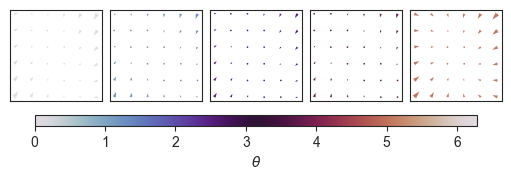

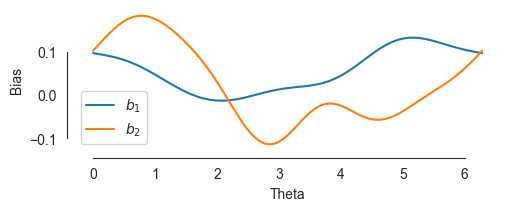

In [22]:
cmap = plt.cm.twilight

def plot_vector_field(A, ax, color='k'):
    x = jnp.linspace(-1, 1, 6)
    y = jnp.linspace(-1, 1, 6)
    X, Y = jnp.meshgrid(x, y)
    U = A[0, 0] * X + A[0, 1] * Y
    V = A[1, 0] * X + A[1, 1] * Y

    # Thicken the arrows
    ax.quiver(X, Y, U, V, units='width', scale=4, width=0.02, color=color)


t = bin_edges[-1]
thetas = jnp.linspace(0, 2*jnp.pi, 100)
As_theta = A_prior(params.dynamics_gp_weights, thetas)
# _theta_conditions = jnp.stack([t * jnp.ones_like(thetas), thetas]).T

fig, axs = plt.subplots(ncols=5, figsize=[5,3], constrained_layout=True)
colors = cmap(jnp.linspace(0, 1, len(axs), endpoint=False))
indices = jnp.linspace(0, len(thetas), len(axs), endpoint=False).astype(int)
for i, j in enumerate(indices):
    plot_vector_field(As_theta[j] - jnp.eye(latent_dim), axs[i], color=colors[i])
    # axs[i].set_title(r'$\theta=$'+f'{thetas[j]:.2f}')

# Add colorbar
norm = plt.Normalize(0, 2*jnp.pi)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=axs, orientation='horizontal', label=r'$\theta$', shrink=0.9, aspect=40)

for ax in axs:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
# plt.savefig('figures/HD_vector_fields_theta.png', format='png', dpi=300)
plt.show()

bs_theta = b_prior(params.bias_gp_weights, thetas).squeeze()
# bs_theta = jnp.einsum('ij,tj->ti', H, bs_theta)

fig, ax = plt.subplots(figsize=[5,2], constrained_layout=True)
ax.plot(thetas, bs_theta[:,0], label='$b_1$')
ax.plot(thetas, bs_theta[:,1], label='$b_2$')
ax.legend()
ax.set_xlabel('Theta')
ax.set_ylabel('Bias')
ax.grid(False)
sns.despine(ax=ax, offset=5, trim=True)
# plt.savefig('figures/HD_bias.png', format='png', dpi=300)
plt.show()
# for i, index in enumerate(indices):
#     ax.plot(*bs_theta[index], 'o', color=colors[i])
# ax.set_aspect('equal')


# sns.despine(ax=ax, offset=5, trim=True)

In [23]:
import postprocessing

theta_range = jnp.linspace(0, 2*jnp.pi, 100)

# Compute composite dynamics
x_bin_edges, y_bin_edges, composite_Fs, U_per_bin, bin_counts = postprocessing.compute_composite_dynamics(
    model, params, theta_range, Y_train, U_train, n_bins=15
)

# Compute fixed points
fixed_points = postprocessing.get_fixed_points(model, params, theta_range, ROTATE=True)

100%|██████████| 156/156 [00:52<00:00,  2.99it/s]


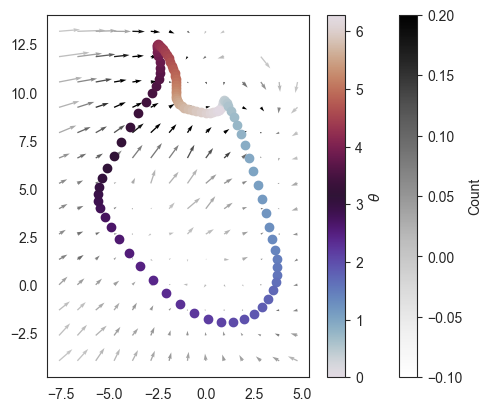

In [24]:
# plot composite dynamics
sns.set_style('white')
cmap = plt.cm.twilight
colors = cmap(jnp.linspace(0,2*jnp.pi,len(fixed_points))/(2*jnp.pi))
cmap_count = plt.cm.Greys
norm_count = plt.Normalize(-0.1, 0.2)

fig, ax = plt.subplots(figsize=[5,4], constrained_layout=True);
ax.quiver(
    *jnp.meshgrid(x_bin_edges, y_bin_edges), *composite_Fs,
    bin_counts.T/jnp.amax(bin_counts), cmap=cmap_count, norm=norm_count, 
    scale=10, width=0.005
    )

for i, fp in enumerate(fixed_points):
    ax.scatter(*fp, color=colors[i])
ax.set_aspect('equal')

# Color of quiver is set by count, lighter means less count (thus more uncertain about calculation)
sm_count = plt.cm.ScalarMappable(cmap=cmap_count, norm=norm_count)
cbar_quiver = plt.colorbar(sm_count, ax=ax, orientation='vertical')
cbar_quiver.set_label('Count')

# Add colorbar for scatter
norm = plt.Normalize(0, 2*jnp.pi)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar_scatter = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar_scatter.set_label(r'$\theta$')
# plt.savefig("figures/HD_activity_fixedpoints_flowfield_2.eps", format='eps')